In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import pickle
from hashlib import md5
import time
import os

def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    
    if(os.path.isdir('./pkl_cache')==False):
        os.makedirs('./pkl_cache')
    
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'pkl_cache/cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'pkl_cache/cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [3]:
prior_model = StanModel_cache(model_code=open("./prior.stan").read())

Using cached StanModel


In [123]:
prior_supp_GP_model = StanModel_cache(model_code=open("./prior with support GP.stan").read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_65845f8e0d4e7ecc80a17c0f4c2a60d4 NOW.


In [124]:
N = 20
xp = np.linspace(-10,4,N)
m_m = np.ones_like(xp,dtype=int)
v_value = 0.00001

prior_data = dict(
    N = N,
    x = xp
)


prior_supp_GP_data = dict(
    N = N,
    x = xp,
    N_g = N,
    x_g = xp,
    m_m = m_m,
    v = v_value
)


N_g = 70
x_g = np.linspace(-10,10,N_g)


In [125]:
prior_fit = prior_model.sampling(data=prior_data,iter=1000,chains=4)


In [126]:
prior_arr = prior_fit.extract(permuted=True)
prior = prior_arr['f']

#### Note:Sampling prior with GP support shows initialization failed often ####

In [131]:
uni_prior_fit = prior_supp_GP_model.sampling(data=prior_supp_GP_data,iter=2000,chains=1)
print(uni_prior_fit)

Inference for Stan model: anon_model_65845f8e0d4e7ecc80a17c0f4c2a60d4.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho         6.32    0.29   1.39   3.97   5.21   6.29   7.29   9.21   23.0   1.08
alpha       0.36    0.11   0.25   0.07   0.16   0.28   0.55   0.88    5.0   1.19
rho_g       6.74    0.85   1.89   3.61   5.39   6.48   8.31  10.42    5.0   1.15
alpha_g     1.27     0.2   0.48   0.64   0.85   1.21   1.61   2.45    6.0   1.11
eta[0]     -1.09    0.49   1.09  -3.24  -1.96  -1.31  -0.09   0.86    5.0   1.06
eta[1]      0.88    0.23   0.41   0.24   0.53   0.78   1.28    1.5    3.0    2.4
eta[2]      0.11    0.42   0.94  -1.51  -0.59   0.03   0.82   1.98    5.0   1.59
eta[3]     -0.32    0.27    0.8  -1.93   -0.9  -0.26   0.29   1.13    9.0   1.31
eta[4]      0.46    0.44   0.99  -1.78  -0.15   0.47   1.26   2.02    5.0   1.42
e

In [133]:
uni_prior_arr = uni_prior_fit.extract(permuted=True)
sim_uni_prior = uni_prior_arr['f']
sim_uni_param = uni_prior_arr['m']

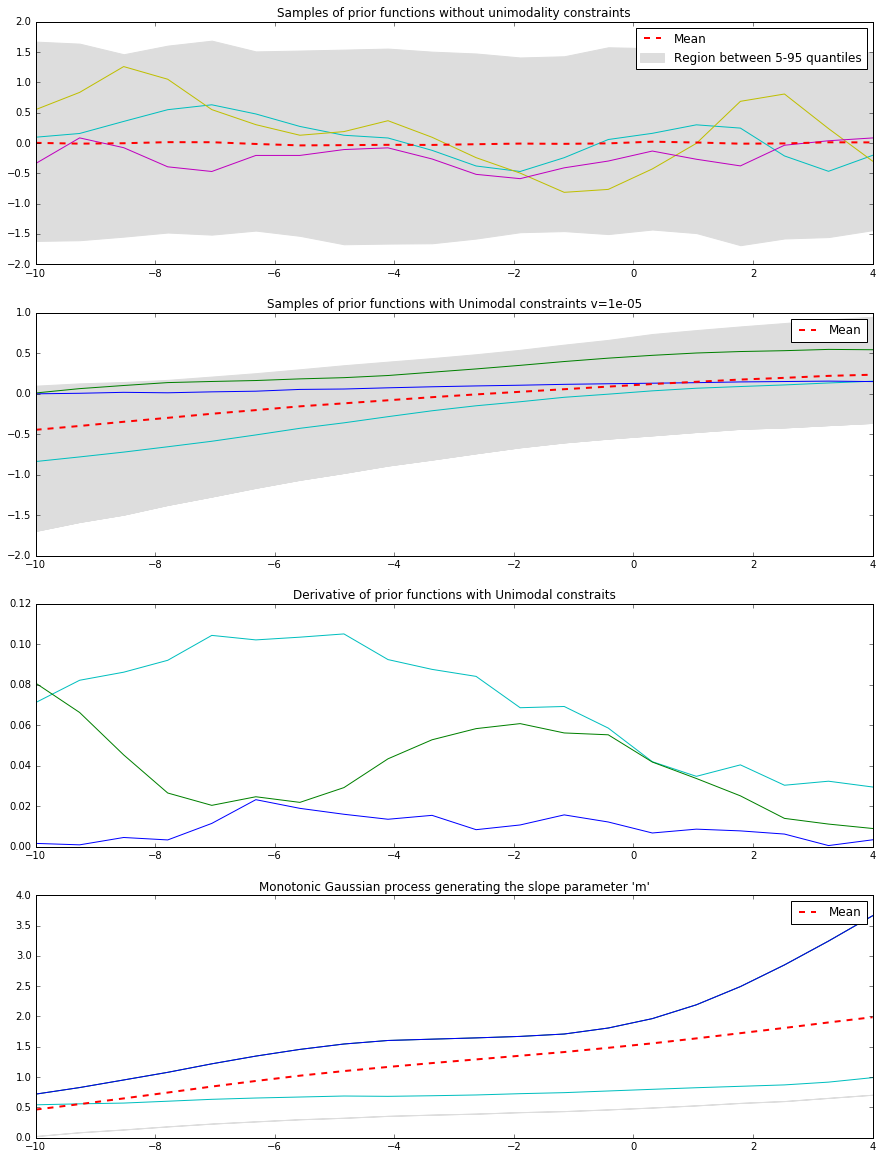

In [135]:
p = np.random.randint(sim_uni_prior.shape[0],size=3)
pp = np.random.randint(prior.shape[0],size=3)
pr_q5 = np.percentile(prior,5,axis=0)
pr_q95 = np.percentile(prior,95,axis=0)
pr_mean = np.mean(prior,axis=0)
m_pr_q5 = np.percentile(sim_uni_prior[0:,:N],5,axis=0)
m_pr_q95 = np.percentile(sim_uni_prior[0:,:N],95,axis=0)
m_pr_mean = np.mean(sim_uni_prior[0:,:N],axis=0)




plt.figure(figsize=(15,20))

ax1 = plt.subplot(411)
plt.title('Samples of prior functions without unimodality constraints')
plt.plot(xp, prior[pp[0]], 'c')
plt.plot(xp, prior[pp[1]], 'y')
plt.plot(xp, prior[pp[2]], 'm')
plt.fill_between(xp, pr_q5, pr_q95, color="#dddddd",label="Region between 5-95 quantiles")
plt.plot(xp,pr_mean,'r--',lw=2,label="Mean" )
plt.legend()


plt.subplot(412)
plt.title('Samples of prior functions with Unimodal constraints v={}'.format(v_value))
plt.plot(xp, sim_uni_prior[p[0]][:N], 'c')
plt.plot(xp, sim_uni_prior[p[1]][:N], 'g')
plt.plot(xp, sim_uni_prior[p[2]][:N], 'b')
plt.fill_between(xp, m_pr_q5, m_pr_q95, color="#dddddd")
plt.fill_between(xp, np.percentile(sim_uni_prior[0:,:N],5,axis=0),np.percentile(sim_uni_prior[0:,:N],5,axis=0), color="#dddddd")
plt.plot(xp,m_pr_mean,'r--',lw=2,label="Mean" )
plt.legend()

plt.subplot(413)
plt.title('Derivative of prior functions with Unimodal constraits')
plt.plot(xp, sim_uni_prior[p[0]][N:], 'c')
plt.plot(xp, sim_uni_prior[p[1]][N:], 'g')
plt.plot(xp, sim_uni_prior[p[2]][N:], 'b')
plt.plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
plt.legend()


plt.subplot(414,sharex=ax1)
plt.title('Monotonic Gaussian process generating the slope parameter \'m\'')
plt.plot(xp, sim_uni_param[p[0]][:N], 'c')
plt.plot(xp, sim_uni_param[p[1]][:N], 'g')
plt.plot(xp, sim_uni_param[p[1]][:N], 'b')
plt.plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
plt.fill_between(xp, np.percentile(sim_uni_param[0:,:N],5,axis=0),np.percentile(sim_uni_param[0:,:N],5,axis=0), color="#dddddd")
plt.plot(xp,np.mean(sim_uni_param[0:,:N],axis=0),'r--',lw=2,label="Mean" )

plt.legend()



plt.legend()
plt.savefig("./Fig/%s Unimodal Prior.png"%(time.ctime()))
plt.show()

# Posterior 

In [141]:
posterior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta) {
        int N = size(x);
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N, N] = sq_alpha + delta;
        return cholesky_decompose(K);
    }
}

data {
    int<lower=1> N;
    real x[N];
    vector[N] y;
    int<lower=1> N_prm;
    real x_prm[N_prm];
    real sig_var;
}

transformed data {
    vector[N] mu;
    int<lower=1> N_tot = N + N_prm;
    real x_tot[N_tot];
    real delta=1e-8;
    
    for (n in 1:N) x_tot[n] = x[n];
    for (n in 1:N_prm) x_tot[N + n] = x_prm[n];
    mu=rep_vector(0,N);
    
    
}

parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
    vector[N_tot] eta;
    real<lower=0.000001> sigma;
}

transformed parameters{
     vector[N_tot] f;
    {
        matrix[N_tot, N_tot] L_K = joint_cov(x_tot,alpha,rho,delta);
        f = L_K * eta;
    }
}


model {    
    rho ~ inv_gamma(1, 2);
    alpha ~ normal(0, 1);
    sigma ~ normal(0,sig_var);
    eta ~ normal(0, 1);
    y ~ normal(f[1:N], sigma);
}

generated quantities {
    vector[N_prm] y_prm;
    for(n in 1:N_prm)
        y_prm[n] = normal_rng(f[N+n], sigma);
}
"""


In [142]:
posterior_model = StanModel_cache(model_code=posterior_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_739053e285994db18766c9936e014ffc NOW.


In [158]:
uni_posterior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta,int Nm,int N) {
        int N1 = N-Nm;
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N1-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N1, N1] = sq_alpha + delta;
        
        for (i in (N1+1):N) {
            for (j in 1:N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((x[j] - x[i])/ square(rho)) ;
                K[j, i] = K[i, j];
            }
        }
        
        for (i in (N1+1):(N-1)) {
            K[i, i] = (sq_alpha /square(rho))+ delta;
            for (j in (i+1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((1-square((x[i] - x[j])/ rho))/square(rho));
                K[j, i] = K[i, j];
            }
        }
        K[N, N] = (sq_alpha/square(rho)) + delta;        
        return cholesky_decompose(K);
    }
}


data {
    int<lower=1> N;
    real x[N];
    vector[N] y;
    int<lower=1> N_g;
    real x_g[N_g];
    int<lower=1> N_prm;
    real x_prm[N_prm];
    real sig_var;
    real v;
    int m_m[N_g];
}

transformed data {
    int<lower=1> N_tot = N + N_prm + N_g;
    vector[N_tot] mu;
    vector[N_g+N_g] mu_m;
    real delta=1e-4;
    real x_tot[N_tot];
    real x_g_tot[N_g+N_g];
    
    
    for (n in 1:N) x_tot[n] = x[n];
    for (n in 1:N_prm) x_tot[N + n] = x_prm[n];
    for (n in 1:N_g) x_tot[N+N_prm + n] = x_g[n];
    mu=rep_vector(0,N_tot);
    
    mu_m=rep_vector(0,N_g+N_g);
    for (n in 1:N_g) x_g_tot[n] = x_g[n];
    for (n in 1:N_g) x_g_tot[N_g + n] = x_g[n];
    
}

parameters {
    real<lower=0.00001> rho;
    real<lower=0.00001> alpha;
    real<lower=0.00001> rho_g;
    real<lower=0.00001> alpha_g;
    vector[N_tot] eta;
    vector[N_g+N_g] eta_g;   
    real<lower=0.000001> sigma;
    
}

transformed parameters{
    vector[N_g+N_g] m;
    vector[N_tot] f;
    {
        matrix[N_tot, N_tot] L_K;
        matrix[(N_g+N_g),(N_g+N_g)] L_K_m;
        
        L_K = joint_cov(x_tot,alpha,rho,delta,N_g,N_tot);
        f = mu + L_K*eta;
        
        L_K_m = joint_cov(x_g_tot,alpha_g,rho_g,delta,N_g,N_g+N_g);
        m = mu_m + L_K_m*eta_g;
        
    }
}

model {    
    rho ~ inv_gamma(5,5);
    alpha ~ normal(0, 1);
    eta ~ normal(0, 1);
    
    rho_g ~ inv_gamma(5,5);
    alpha_g ~ normal(0, 1);
    eta_g ~ normal(0, 1);
    sigma ~ normal(0,sig_var);
    
    y ~ normal(f[1:N], sigma);
    
    
    for(i in 1:N_g){
        target+= log((1-inv_logit(m[i]/v))*(1-inv_logit(f[N+N_prm+i]/v)) + inv_logit(m[i]/v)*inv_logit(f[N+N_prm+i]/v));
        target+= log((1-inv_logit(m_m[i]/v))*(1-inv_logit(m[N_g+i]/v)) + inv_logit(m_m[i]/v)*inv_logit(m[N_g+i]/v));
    }
    
}

generated quantities{
    vector[N_prm] y_prm;
    for(n in 1:N_prm)
        y_prm[n] = normal_rng(f[N+n],sigma);
}
"""

In [159]:
uni_posterior_model = StanModel_cache(model_code=uni_posterior_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92a90daa2cc3d689c36f74b634a53544 NOW.


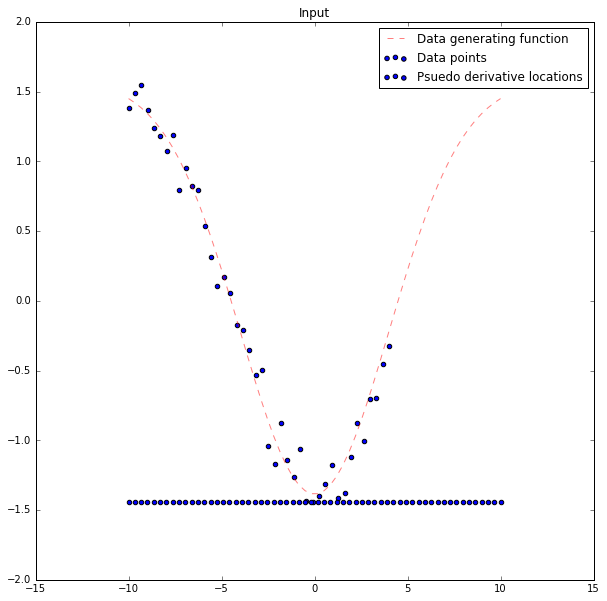

In [168]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def func(x):
    return 1-gaussian(x,0,4) #+ gaussian(x,-5,0.4)*0.05


leng = 60
lendata = 42
#lenpred = 20

xdata = np.linspace(-10,4,lendata)
ydata = func(xdata) + np.random.normal(0,0.005,size=len(xdata))
x = np.linspace(-10,10,leng)
y = func(x) 
#xpred = np.linspace(4,10,lenpred)
ycombined = preprocessing.scale(np.append(ydata,y))
ydata = ycombined[:len(xdata)]
y = ycombined[len(xdata):]

plt.figure(figsize=(10,10))
plt.scatter(xdata,ydata,label="Data points")
plt.plot(x,y,'r--',alpha=0.5,label="Data generating function")
plt.scatter(x,np.zeros_like(x)+np.min(ycombined),label="Psuedo derivative locations")
plt.title('Input')

plt.legend()
plt.savefig("./Fig/%s Input data points.png"%(time.ctime()))

plt.show()

In [169]:
sig =0.05
v= 0.001

posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_prm = len(x),
    x_prm = x,
    sig_var = sig
)

uni_posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_g = len(x),
    x_g = x,
    m_m = np.ones_like(x,dtype=int),
    N_prm = len(x),
    x_prm = x,
    v = v,
    sig_var = sig
)

In [ ]:
posterior_fit = posterior_model.sampling(data=posterior_data,iter=1000,chains=1)
print(posterior_fit)

In [ ]:
uni_posterior_fit = uni_posterior_model.sampling(data=uni_posterior_data,iter=1000,chains=1)
print(uni_posterior_fit)

In [163]:
sim_posterior = posterior_fit.extract(permuted=True)['y_prm']
p_mean = np.mean(sim_posterior,axis=0)
p_std = np.std(sim_posterior,axis=0)
p_q5 = np.percentile(sim_posterior, 5, axis=0)
p_q95 = np.percentile(sim_posterior, 95, axis=0)


In [164]:
uni_sim_posterior = uni_posterior_fit.extract(permuted=True)['y_prm']
u_p_mean = np.mean(uni_sim_posterior,axis=0)
u_p_std = np.std(uni_sim_posterior,axis=0)
u_p_q5 = np.percentile(uni_sim_posterior, 5, axis=0)
u_p_q95 = np.percentile(uni_sim_posterior, 95, axis=0)

uni_sim_param = uni_posterior_fit.extract(permuted=True)['m']
uni_sim_der   = uni_posterior_fit.extract(permuted=True)['f']


ValueError: Argument dimensions are incompatible

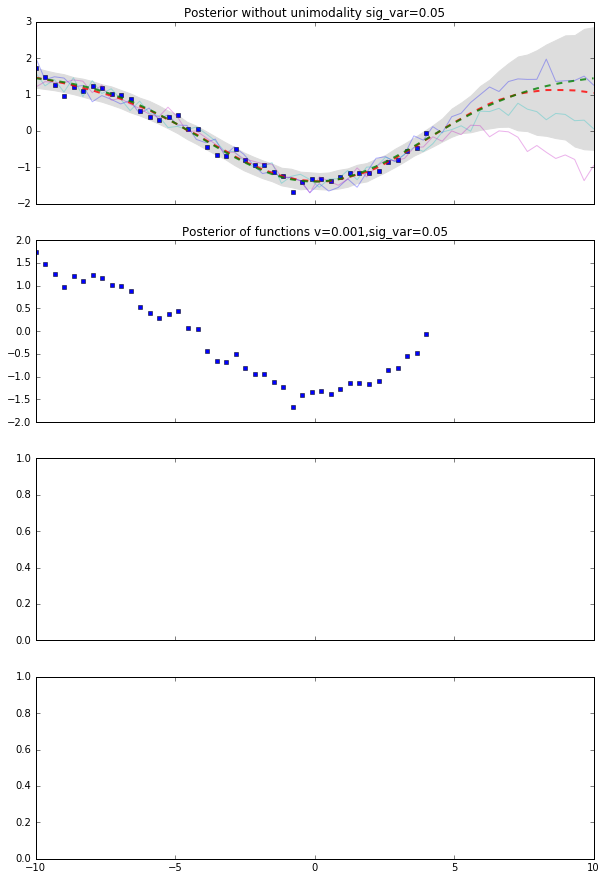

In [165]:
c = ['b', 'c', 'm', 'y']
p = np.random.randint(sim_posterior.shape[0],size=3)
pp = np.random.randint(uni_sim_posterior.shape[0],size=3)


fig,ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(10,15)
ax[0].set_title('Posterior without unimodality sig_var={}'.format(sig))
ax[0].plot(xdata, ydata, 'bs', ms=4,label="Data points")#  
ax[0].plot(x, sim_posterior[p[0]], c[0],alpha=0.3,label="posterior1")
ax[0].plot(x, sim_posterior[p[1]], c[1],alpha=0.3,label="posterior2")
ax[0].plot(x, sim_posterior[p[2]], c[2],alpha=0.3,label="posterior3")
ax[0].plot(x, p_mean,'r--',alpha=0.8,lw=2,label="mean of posterior simulations")
ax[0].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
ax[0].fill_between(x, p_q5, p_q95, color="#dddddd")
#ax[0].legend()


#plt.subplot(2,2,2)
ax[1].set_title('Posterior of functions v={},sig_var={}'.format(v,sig))
ax[1].plot(xdata, ydata, 'bs', ms=4,label="Data points")#
ax[1].fill_between(x, u_p_q5, u_p_q95, color="#dddddd")
ax[1].plot(x, uni_sim_posterior[pp[0]], c[1],alpha=0.3,label="posterior-function1")
ax[1].plot(x, uni_sim_posterior[pp[1]], c[2],alpha=0.3,label="posterior-function2")
ax[1].plot(x, uni_sim_posterior[pp[2]], c[3],alpha=0.3,label="posterior-function3")
ax[1].plot(x, u_p_mean, 'r--',alpha=0.8, lw=2,label="mean of posterior simulations")
ax[1].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
#ax[1].legend()


#plt.subplot(413)
ax[2].set_title('Derivative of posterior functions with Unimodal constraits')
ax[2].plot(x, uni_sim_der[p[0]][lenx+lendata:], 'c')
ax[2].plot(x, uni_sim_der[p[1]][lenx+lendata:], 'g')
ax[2].plot(x, uni_sim_der[p[2]][lenx+lendata:], 'b')
ax[2].plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
ax[2].plot(x,np.mean(uni_sim_der[0:,lenx+lendata:],axis=0),'r--',lw=2,label="Mean" )

#ax[2].legend()


#ax[3].subplot(414,sharex=ax1)
ax[3].set_title('Monotonic Gaussian process generating the slope parameter \'m\'')
ax[3].plot(x, uni_sim_param[p[0]][:lenx], 'c')
ax[3].plot(x, uni_sim_param[p[1]][:lenx], 'g')
ax[3].plot(x, uni_sim_param[p[1]][:lenx], 'b')
ax[3].plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
ax[3].fill_between(x, np.percentile(uni_sim_param[0:,:lenx],5,axis=0),np.percentile(uni_sim_param[0:,:lenx],5,axis=0), color="#dddddd")
ax[3].plot(x,np.mean(uni_sim_param[0:,:lenx],axis=0),'r--',lw=2,label="Mean" )


plt.savefig("./Figs/%s Posterior.png"%(time.ctime()))
plt.show()